In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import networkx as nx
import ast

from nanonets import Simulation
from nanonets.utils import fft, total_harmonic_distortion, cross_correlation, BLUE_COLOR, RED_COLOR
from nanonets.utils import display_network, update_circle_colors, get_net_currents, create_weighted_undirected_graph, display_net_flow_graph
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from scipy import signal

plt.style.use(["science","bright","grid"])
PATH        = "/home/j/j_mens07/phd/data/2_funding_period/dynamic/AC/res_disorder/"
PATH_U      = "/home/j/j_mens07/phd/data/2_funding_period/dynamic/AC/amp_freq/"
NET_PATHS   = "/home/j/j_mens07/phd/nanonets/scripts/2_funding_period/WP2/data/"

# PATH = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/res_disorder/"
# PATH_U = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/amp_freq/"
# NET_PATHS = "/home/jonasmensing/bagheera/nanonets/scripts/2_funding_period/WP2/data/"
# PATH_10 = "/home/jonasmensing/data/"

### Load Output Data

In [ ]:
N_PERIODS, SAMPLE_P_PERIOD  = 100, 40
N_NP, N_ELECTRODES          = 9, 8
N_SKIP, N_NETS              = 80, 32
AMPLITUDE                   = 0.02
FREQ_LIST_MHZ               = [0.06,0.12,0.25,0.5,1.,2.,5.,6.,8.,10.,12.,15.,18.,23.,28.,36.,44.,55.,68.,86.]
R_VALS                      = [50,100,200,400,800,1600]
F0                          = 10.0

topo = {"Nx": N_NP,"Ny": N_NP, "e_pos": [[(N_NP-1)//2, 0],[0, 0],[N_NP-1, 0],
               [0, (N_NP-1)//2],[N_NP-1, (N_NP-1)//2],[0, N_NP-1],
               [N_NP-1, N_NP-1],[(N_NP-1)//2, N_NP-1]],
            "electrode_type": ['constant']*8}
sim_class   = Simulation(topo)
G_obj       = sim_class.get_graph()
pos         = sim_class.get_positions()
pos         = {(key+8 if key >= 0 else (abs(key)-1)) : (val) for key, val in pos.items()}
E_CHARGE    = sim_class.ELE_CHARGE_A_C
CAP_MAT     = sim_class.get_capacitance_matrix()

In [ ]:
dts         = {freq : 1/(40 * freq * 1e6) for freq in FREQ_LIST_MHZ}
N_steps     = {freq : int(np.ceil((N_PERIODS / (freq * 1e6)) / dts[freq])) for freq in FREQ_LIST_MHZ}
time        = {freq : dts[freq]*np.arange(N_steps[freq]) for freq in FREQ_LIST_MHZ}
# data_u      = {freq : pd.read_csv(f"{PATH_U}Nx=9_Ny=9_Ne=8_{freq:.3f}_{0.02:.3f}_constant.csv") for freq in FREQ_LIST_MHZ}
data        = {}
states      = {}
currents    = {}
currents_u  = {}
pots        = {}
pots_u      = {}
for R in R_VALS:
    pots[R]         = {n : pd.read_csv(f"{PATH}mean_state_Nx=9_Ny=9_Ne=8_10.000_mean2_{R:.1f}_{n}.csv") for n in range(N_NETS)}
    pots_u[R]       = pd.read_csv(f"{PATH_U}mean_state_Nx=9_Ny=9_Ne=8_10.000_mean2_{R:.1f}.csv")
    # data[R]     = {n : {freq : pd.read_csv(f"{PATH}Nx=9_Ny=9_Ne=8_{freq:.3f}_mean2_{R:.1f}_{n}.csv") for freq in FREQ_LIST_MHZ} for n in range(N_NETS)}
    # states[R]   = {n : {freq : pd.read_csv(f"{PATH}mean_state_Nx=9_Ny=9_Ne=8_{freq:.3f}_mean2_{R:.1f}_{n}.csv") for freq in FREQ_LIST_MHZ} for n in range(N_NETS)}
    currents[R]     = {n : pd.read_csv(f"{PATH}net_currents_Nx=9_Ny=9_Ne=8_{F0:.3f}_mean2_{R:.1f}_{n}.csv").iloc[N_SKIP*SAMPLE_P_PERIOD:,:]*1e-6 for n in range(N_NETS)}
    currents_u[R]   = pd.read_csv(f"{PATH_U}net_currents_Nx=9_Ny=9_Ne=8_{F0:.3f}_mean2_{R:.1f}.csv").iloc[N_SKIP*SAMPLE_P_PERIOD:,:]*1e-6

In [198]:
ijs  = [12+9*i for i in range(9)]
nijs = [8+i for i in range(9)] + [8+81-i for i in range(9)] + [8+8+i*9 for i in range(1,8)] + [8+i*9 for i in range(1,8)]

R   = 100
n   = 0
f0  = 10
Pij_df = pd.DataFrame()
Pnij_df = pd.DataFrame()
for R in [100,1600]:
    Pij = {}
    Pnij = {}
    for n in range(N_NETS):
        b = 0
        for col, val in get_net_currents(currents[R][n][f0]).items():
            i,j = eval(col)
            if ((i in ijs) and (j in ijs)):
                v_i = pots[R][n].iloc[N_SKIP*SAMPLE_P_PERIOD:,i].values
                v_j = pots[R][n].iloc[N_SKIP*SAMPLE_P_PERIOD:,j].values
                I_v = val.values
                P_v = I_v * (v_j - v_i)
                if n == 0:
                    Pij[(i-3)/9] = [np.mean(P_v)]
                else:
                    Pij[(i-3)/9].append(np.mean(P_v))
            if ((i not in nijs) and (j not in nijs)):
                v_i = pots[R][n].iloc[N_SKIP*SAMPLE_P_PERIOD:,i].values
                v_j = pots[R][n].iloc[N_SKIP*SAMPLE_P_PERIOD:,j].values
                I_v = val.values
                P_v = I_v * (v_j - v_i)
                if n == 0:
                    Pnij[b] = [np.mean(P_v)]
                else:
                    Pnij[b].append(np.mean(P_v))
                b += 1
    df_tmp      = pd.DataFrame(Pij)
    df_tmp['R'] = R

    Pij_df      = pd.concat([Pij_df,df_tmp],ignore_index=True)

    df_tmp      = pd.DataFrame(Pnij)
    df_tmp['R'] = R

    Pnij_df     = pd.concat([Pnij_df,df_tmp],ignore_index=True)

/tmp/ipykernel_5249/2623836168.py:13: UserWarning: Mismatched number of handles and labels: len(handles) = 0 len(labels) = 2
  _ = ax.legend(handles=handles, labels=new_labels, loc="upper right", fontsize='small', ncol=1)
/tmp/ipykernel_5249/2623836168.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  _ = ax.legend(handles=handles, labels=new_labels, loc="upper right", fontsize='small', ncol=1)


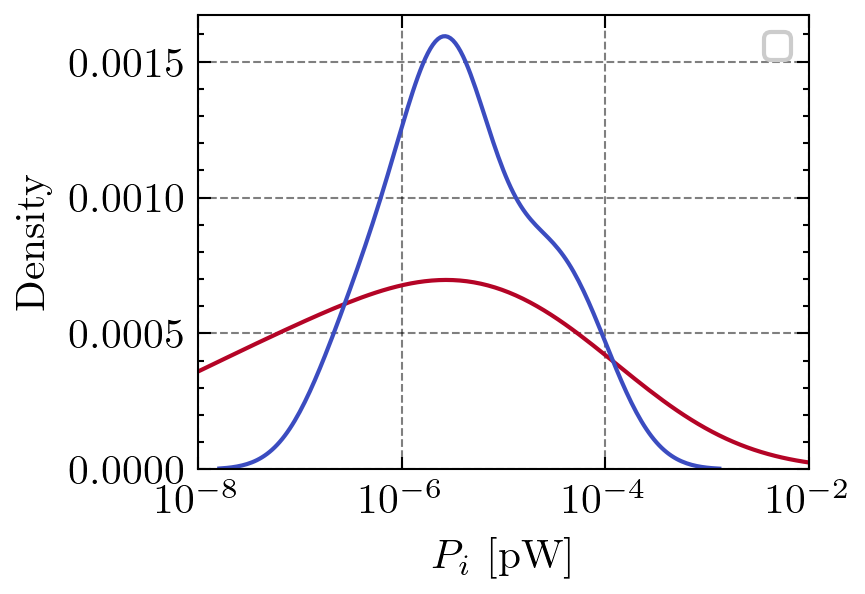

In [ ]:
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

ax  = sns.kdeplot(Pnij_df.melt(id_vars='R'), x='value', hue='R', log_scale=True, fill=False, palette='coolwarm')
_   = ax.set_xlabel("$P_i~[\mathrm{pW}]$")
_   = ax.set_xlim(1e-8,1e-2)

handles, labels = ax.get_legend_handles_labels()
new_labels = [f"$\\kappa = {int(R/25)}$" for R in [100,1600]]
_ = ax.legend(handles=handles, labels=new_labels, loc="upper right", fontsize='small', ncol=1)

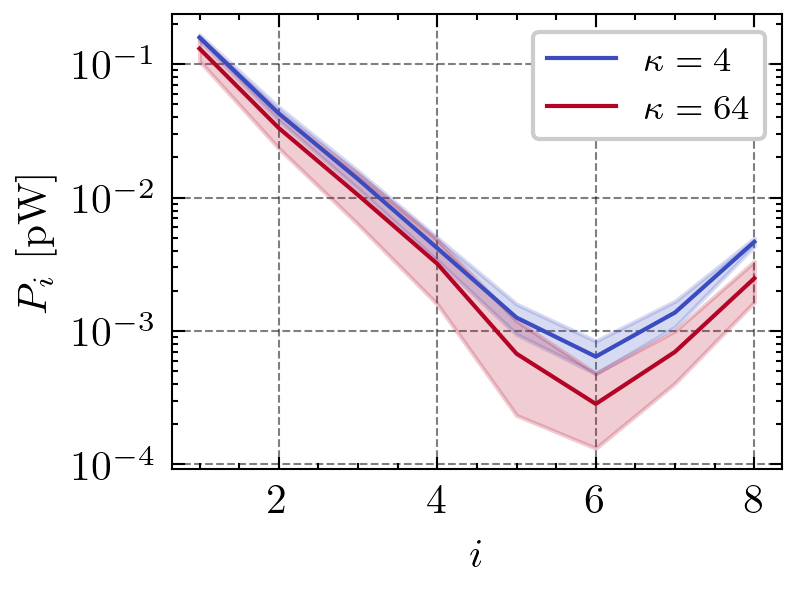

In [156]:
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

ax  = sns.lineplot(data=Pij_df.melt(id_vars='R').abs(), x='variable', y='value', hue='R', palette='coolwarm')
_   = ax.set_yscale('log')
_   = ax.set_xlabel("$i$")
_   = ax.set_ylabel("$P_i~[\mathrm{pW}]$")

handles, labels = ax.get_legend_handles_labels()
new_labels = [f"$\\kappa = {int(R/25)}$" for R in [100,1600]]
_ = ax.legend(handles=handles, labels=new_labels, loc="upper right", fontsize='small', ncol=1)

/tmp/ipykernel_5249/3842690280.py:16: UserWarning: Mismatched number of handles and labels: len(handles) = 0 len(labels) = 2
  _ = ax.legend(handles=handles, labels=new_labels, loc="upper right", fontsize='small', ncol=1)
/tmp/ipykernel_5249/3842690280.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  _ = ax.legend(handles=handles, labels=new_labels, loc="upper right", fontsize='small', ncol=1)


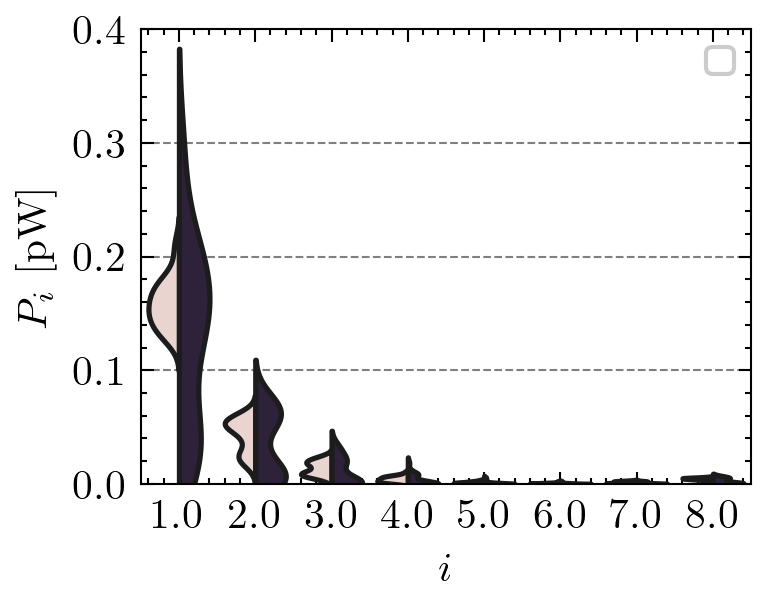

In [165]:
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

ax  = sns.violinplot(data=Pij_df.melt(id_vars='R').abs(), x='variable', y='value', hue='R',
                     fill=True, inner=None, density_norm='width', split=True, legend=False)
_   = ax.set_xlabel("$i$")
_   = ax.set_ylabel("$P_i~[\mathrm{pW}]$")
# _   = ax.set_yscale('log')
_   = ax.set_ylim(0,0.4)

handles, labels = ax.get_legend_handles_labels()
new_labels = [f"$\\kappa = {int(R/25)}$" for R in [100,1600]]
_ = ax.legend(handles=handles, labels=new_labels, loc="upper right", fontsize='small', ncol=1)
# _   = ax.set_ylim(0.01,10)
# _   = ax.set_yscale('log')

# fig.savefig("plots/png/volt_drop_input_to_output_disorder.png", transparent=False)
# fig.savefig("plots/svg/volt_drop_input_to_output_disorder.svg", transparent=True)
# fig.savefig("plots/pdf/volt_drop_input_to_output_disorder.pdf", transparent=False)

/tmp/ipykernel_5249/3120347209.py:16: UserWarning: Mismatched number of handles and labels: len(handles) = 0 len(labels) = 2
  _ = ax.legend(handles=handles, labels=new_labels, loc="upper right", fontsize='small', ncol=1)
/tmp/ipykernel_5249/3120347209.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  _ = ax.legend(handles=handles, labels=new_labels, loc="upper right", fontsize='small', ncol=1)


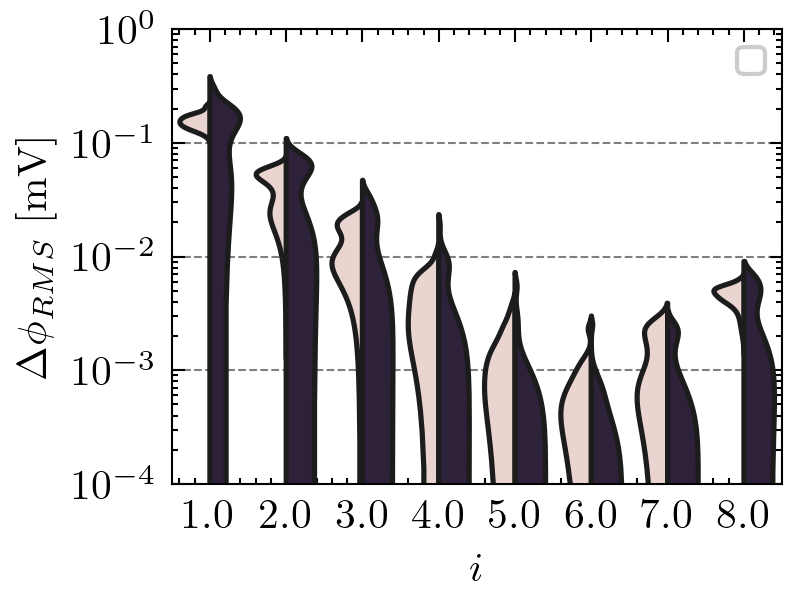

In [158]:
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

ax  = sns.violinplot(data=Pij_df.melt(id_vars='R').abs(), x='variable', y='value', hue='R',
                     fill=True, inner=None, density_norm='width', split=True, legend=False)
_   = ax.set_xlabel("$i$")
_   = ax.set_ylabel("$\Delta \phi_{RMS}~[\mathrm{mV}]$")
_   = ax.set_yscale('log')
_   = ax.set_ylim(1e-4,1)

handles, labels = ax.get_legend_handles_labels()
new_labels = [f"$\\kappa = {int(R/25)}$" for R in [100,1600]]
_ = ax.legend(handles=handles, labels=new_labels, loc="upper right", fontsize='small', ncol=1)
# _   = ax.set_ylim(0.01,10)
# _   = ax.set_yscale('log')

# fig.savefig("plots/png/volt_drop_input_to_output_disorder.png", transparent=False)
# fig.savefig("plots/svg/volt_drop_input_to_output_disorder.svg", transparent=True)
# fig.savefig("plots/pdf/volt_drop_input_to_output_disorder.pdf", transparent=False)

In [17]:
pot_diff = {R : [np.sqrt(np.mean(np.diff(pots[R][i].iloc[:SAMPLE_P_PERIOD//2,8:].values.reshape(20,9,9),axis=1)**2,axis=0))[:,9//2]*1000 for i in range(N_NETS)] for R in R_VALS}

In [159]:
currents[100][0][0.06]

,"(0, 12)","(1, 8)","(2, 16)","(3, 44)","(4, 52)","(5, 80)","(6, 88)","(7, 84)","(8, 1)","(8, 9)",...,"(85, 86)","(86, 77)","(86, 85)","(86, 87)","(87, 78)","(87, 86)","(87, 88)","(88, 6)","(88, 79)","(88, 87)"
3200,5.048888e-06,8.792369e-35,1.401324e-31,1.646648e-02,2.763247e-02,6.790470e-37,4.305901e-36,1.190270e-02,2.152991e-187,2.551200e-202,...,6.773313e-187,1.223766e-12,3.457327e-187,4.282303e-200,9.515852e-185,3.847493e-192,5.613704e-216,1.281196e-187,1.042722e-204,2.026181e-203
3201,3.970299e+00,2.673157e-47,5.105205e-48,4.108399e-19,2.369340e-16,2.299069e-46,1.067009e-44,2.007260e-16,1.016880e-67,1.618462e-206,...,1.968160e-188,1.862337e-14,4.177432e-190,1.025239e-197,1.501367e-186,1.043847e-193,3.033648e-208,2.973974e-76,4.119251e-207,1.098342e-205
3202,8.900356e+00,4.307395e-05,1.521083e-05,1.359602e-04,3.004896e-03,3.134283e-168,3.261279e-168,6.733990e-03,9.031811e-02,4.128082e-218,...,2.993253e-186,3.802922e-185,2.130244e-183,5.545147e-195,6.491207e-193,2.031485e-199,8.280438e-204,3.807169e-12,6.526878e-215,1.456312e-215
3203,1.454023e+01,1.650055e-02,1.422200e-02,8.579339e-05,2.183734e-03,1.546414e-203,5.631201e-203,2.194094e-03,2.092589e+00,9.385953e-07,...,3.016538e-187,1.224353e-185,1.900941e-12,1.360886e-195,3.050812e-193,2.401328e-197,1.195244e-203,9.382015e-04,5.120210e-216,9.468468e-217
3204,4.276066e+01,5.420862e-05,2.363802e-03,8.479698e-04,1.927469e-07,7.537653e-02,5.954744e-02,7.195690e-04,1.145666e+01,2.076164e-11,...,1.050341e-07,2.031120e-19,2.248535e-06,9.039403e-02,7.151785e-19,4.080400e-09,4.558952e-01,4.445388e-01,2.950302e-19,4.100845e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,5.742702e-04,1.625494e+01,1.219322e+01,1.136308e+01,1.016437e+01,1.425303e+00,1.280571e+00,3.109648e+00,2.139173e-03,1.271021e+01,...,1.513677e-03,2.304171e-01,1.099298e-02,8.002216e-07,9.924911e-01,3.293349e-01,2.954005e-16,9.861558e-02,3.058771e-01,1.104300e+00
3996,8.256264e-45,1.186974e+01,8.343259e+00,8.891458e+00,8.338845e+00,4.917512e-01,5.269429e-01,3.432208e+00,1.001257e-03,9.962015e+00,...,2.006832e-05,2.813958e-02,2.628029e-02,3.157065e-09,1.392786e-01,4.797626e-02,6.708525e-17,7.028801e-02,8.937757e-02,3.303933e-01
3997,1.220196e-02,2.307038e+00,1.129409e+00,4.011075e+00,4.684481e+00,1.220862e-03,1.672192e-03,1.540707e+00,3.931057e-03,1.713245e+00,...,1.173505e-182,2.853773e-174,1.154139e-187,8.378018e-199,1.033698e-186,8.958534e-196,1.328196e-216,6.161027e-202,1.825728e-203,1.334969e-203
3998,1.890381e-33,3.054179e-01,1.595572e-01,3.104439e+00,2.829356e+00,9.230719e-11,8.065148e-08,9.703305e-01,1.719439e-05,2.945550e-01,...,1.327339e-05,8.320451e-174,2.257092e-188,9.896282e-194,2.780715e-181,5.234984e-196,1.607522e-216,2.427401e-199,1.694581e-202,7.427488e-204


In [160]:
df          = pd.DataFrame(pot_diff).melt(var_name='R')
new_cols    = pd.DataFrame(df['value'].tolist(), index=df.index)
df          = df.join(new_cols).drop(columns='value').melt(id_vars='R')
df

,R,variable,value
0,50,0,2.828168
1,50,0,3.919299
2,50,0,2.958873
3,50,0,2.996222
4,50,0,2.886797
...,...,...,...
1531,1600,7,0.915027
1532,1600,7,0.933046
1533,1600,7,1.521105
1534,1600,7,0.766028


/tmp/ipykernel_5249/3535375637.py:7: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax  = sns.violinplot(data=df[(df['R']==100) | (df['R']==1600)], x='variable', y='value', hue='R', fill=True, inner=None, scale='width', split=True, legend=False)
/tmp/ipykernel_5249/3535375637.py:14: UserWarning: Mismatched number of handles and labels: len(handles) = 0 len(labels) = 2
  _ = ax.legend(handles=handles, labels=new_labels, loc="upper right", fontsize='small', ncol=1)
/tmp/ipykernel_5249/3535375637.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  _ = ax.legend(handles=handles, labels=new_labels, loc="upper right", fontsize='small', ncol=1)


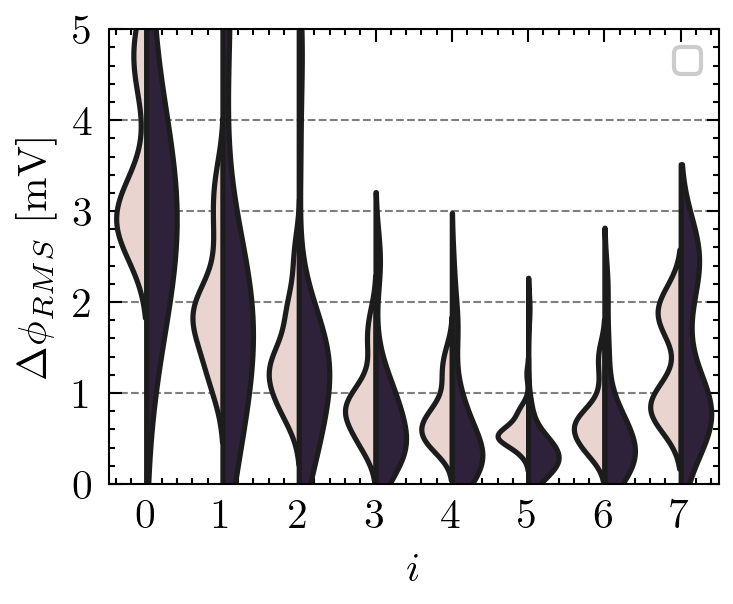

In [21]:
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

ax  = sns.violinplot(data=df[(df['R']==100) | (df['R']==1600)], x='variable', y='value', hue='R', fill=True, inner=None, scale='width', split=True, legend=False)
_   = ax.set_xlabel("$i$")
_   = ax.set_ylabel("$\Delta \phi_{RMS}~[\mathrm{mV}]$")
_   = ax.set_ylim(0,5)

handles, labels = ax.get_legend_handles_labels()
new_labels = [f"$\\kappa = {int(R/25)}$" for R in [100,1600]]
_ = ax.legend(handles=handles, labels=new_labels, loc="upper right", fontsize='small', ncol=1)
# _   = ax.set_ylim(0.01,10)
# _   = ax.set_yscale('log')

# fig.savefig("plots/png/volt_drop_input_to_output_disorder.png", transparent=False)
# fig.savefig("plots/svg/volt_drop_input_to_output_disorder.svg", transparent=True)
# fig.savefig("plots/pdf/volt_drop_input_to_output_disorder.pdf", transparent=False)

ValueError: There must be exactly two hue levels to use `split`.'

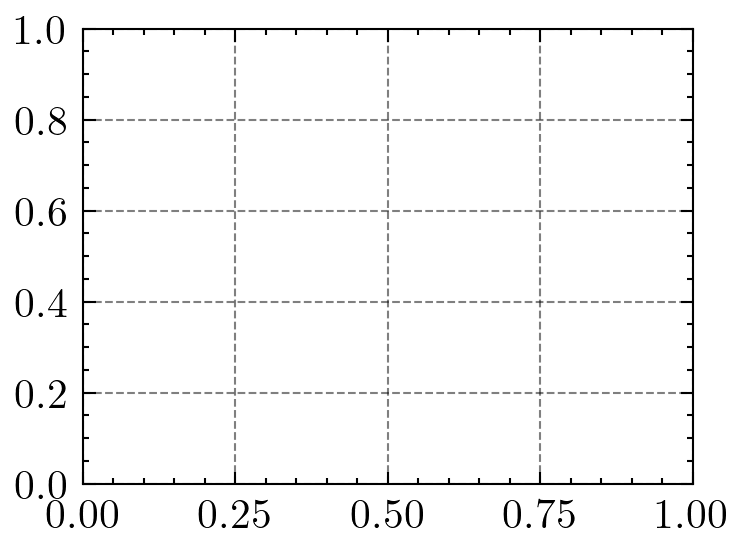

In [14]:
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

ax  = sns.violinplot(data=df, x='variable', y='value', hue='R', fill=True, inner=None, density_norm='width', split=True, palette='cividis', legend=False)
_   = ax.set_xlabel("$i$")
_   = ax.set_ylabel("$\Delta \phi_{RMS}~[\mathrm{mV}]$")
_   = ax.legend([f"$\\kappa = {k}$" for k in [2,4,8,16,32,64]], fontsize='x-small', ncol=2, loc='upper right')
_   = ax.set_ylim(0,10)
# _   = ax.set_ylim(0.01,10)
# _   = ax.set_yscale('log')

# fig.savefig("plots/png/volt_drop_input_to_output_disorder.png", transparent=False)
# fig.savefig("plots/svg/volt_drop_input_to_output_disorder.svg", transparent=True)
# fig.savefig("plots/pdf/volt_drop_input_to_output_disorder.pdf", transparent=False)

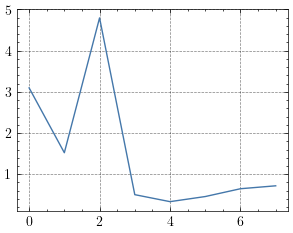

In [30]:
plt.plot(pot_diff[1600][20])

In [ ]:
for i, N in enumerate(N_PARTICLES):
    _ = ax.plot(np.arange(N-1)/(N-2), np.sqrt(np.mean(np.diff(pots[N].reshape(800,N,N)[:SAMPLE_P_PERIOD//2,:,:],axis=1)**2,axis=0))[:,N//2]*1000,
                marker=mss[i], label=f'$L = {N}$')

In [ ]:
np.sqrt(np.mean(np.diff(pots[N].reshape(800,N,N)[:SAMPLE_P_PERIOD//2,:,:],axis=1)**2,axis=0))[:,N//2]*1000

In [4]:
# p   = {R : {n : {freq : states[R][n][freq].iloc[:,8:].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for n in range(N_NETS)} for R in R_VALS}
x       = {R : {n : {freq : data[R][n][freq]['E0'].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for n in range(N_NETS)} for R in R_VALS}
y       = {R : {n : {freq : data[R][n][freq]['Observable'].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for n in range(N_NETS)} for R in R_VALS}
y_e     = {R : {n : {freq : data[R][n][freq]['Error'].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for n in range(N_NETS)} for R in R_VALS}
y_u     = {freq : data_u[freq]['Observable'].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ}
y_u_e   = {freq : data_u[freq]['Error'].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ}

### Gain Plots

In [5]:
def extract_harmonic_features(y_val, n_vals, N_periods=20, search_range=3, mode='complex'):
    """
    Extracts harmonic features from a time series using FFT, handling spectral leakage
    and phase referencing relative to the fundamental.

    Parameters:
    -----------
    y_val : array-like
        Input time series (current or voltage).
    n_vals : array-like of int
        List of harmonic orders to extract (e.g., [1, 2, 3] or [2, 3, 4]).
    N_periods : float, default=20
        Number of full periods of the fundamental frequency contained in y_val.
        Used to identify the FFT bin index of the fundamental.
    search_range : int, default=3
        Number of FFT bins to search left/right of the ideal index to account for leakage.
    mode : str, default='complex'
        - 'complex': Returns [Re, Im] pairs relative to fundamental phase.
                     Output length = 2 * len(n_vals). Use for VOLUME analysis.
        - 'abs':     Returns [Magnitude]. Output length = len(n_vals).
                     Use for THD / CENTROID analysis.
        - 'projected': Returns [Magnitude * cos(delta_phi)]. Output length = len(n_vals).
                     Projects harmonic onto the fundamental's real axis. (Lossy).

    Returns:
    --------
    np.ndarray
        Array of feature values. Structure depends on 'mode'.
    """
    
    # 1. Preprocessing: Detrend and Window
    # Remove DC offset to prevent 0-Hz peak from leaking
    y_val = np.array(y_val)
    y_val = y_val - np.mean(y_val)
    
    N_samples = len(y_val)
    
    # Blackman window is excellent for harmonic separation (low sidelobes)
    window = np.blackman(N_samples)
    y_windowed = y_val * window
    
    # Coherent Gain Correction (compensates for energy lost due to windowing)
    w_gain = np.sum(window) / N_samples
    
    # 2. FFT Calculation
    # rfft is faster for real-valued inputs and returns only positive frequencies
    fft_vals = np.fft.rfft(y_windowed)
    
    # 3. Find Fundamental Phase (Reference Frame)
    # We must lock all phases to the fundamental to make the features shift-invariant
    k_fund_ideal = int(round(1.0 * N_periods))
    
    # Define search window for fundamental
    f_start = max(0, k_fund_ideal - search_range)
    f_end   = min(len(fft_vals), k_fund_ideal + search_range + 1)
    
    # Extract fundamental phasor
    fund_neighborhood = fft_vals[f_start:f_end]
    
    # Safety check: if signal is effectively zero or noise
    if len(fund_neighborhood) > 0 and np.max(np.abs(fund_neighborhood)) > 1e-12:
        idx_peak = np.argmax(np.abs(fund_neighborhood))
        Z_fund = fund_neighborhood[idx_peak]
        phi_1 = np.angle(Z_fund)
    else:
        # Fallback if no fundamental is found (e.g., DC input)
        phi_1 = 0.0

    features = []

    # 4. Extract Harmonics
    for m in n_vals:
        # Ideal bin for m-th harmonic
        k_ideal = int(round(m * N_periods))
        
        # Search window
        start = max(0, k_ideal - search_range)
        end   = min(len(fft_vals), k_ideal + search_range + 1)
        
        # Check bounds
        if start < len(fft_vals) and start < end:
            neighborhood = fft_vals[start:end]
            idx_in_neighborhood = np.argmax(np.abs(neighborhood))
            Z_m = neighborhood[idx_in_neighborhood]
            
            # Physical Magnitude (Peak Amplitude)
            # Factor of 2 accounts for negative frequencies discarded by rfft
            mag = (np.abs(Z_m) * 2 / N_samples) / w_gain
            
            # Phase relative to fundamental
            # The condition for a stationary waveform shape is: phi_m - m * phi_1
            phi_m = np.angle(Z_m)
            delta_phi = phi_m - (m * phi_1)
            
            if mode == 'complex':
                # Map to 2D plane: (x, y) coordinates for volume
                # This preserves full shape information
                features.append(mag * np.cos(delta_phi))
                features.append(mag * np.sin(delta_phi))
                
            elif mode == 'projected':
                # Scalar projection (Lossy: 90-degree phase shift yields 0)
                features.append(mag * np.cos(delta_phi))
                
            else: # mode == 'abs'
                # Pure magnitude (Standard spectrum)
                features.append(mag)
                
        else:
            # Handle out-of-bounds frequencies (e.g., Nyquist limit)
            if mode == 'complex':
                features.extend([0.0, 0.0])
            else:
                features.append(0.0)
                
    return np.array(features)

In [219]:
# Reference
h0s     = np.array([extract_harmonic_features(y_u[f0], [1], mode='abs') for f0 in FREQ_LIST_MHZ])
gain_u  = h0s/h0s[0]

# Disorder
gain_data = {}
for R in R_VALS:
    gain_data[R] = {}
    for N in range(N_NETS):
        h0s     = np.array([extract_harmonic_features(y[R][N][f0], [1], mode='abs') for f0 in FREQ_LIST_MHZ])
        ratio   = h0s/h0s[0]
        gain_dB = 20*np.log10(ratio)
        
        gain_data[R][N] = gain_dB

# Max Gain
deltaG                      = pd.DataFrame([[(np.max(gain_data[R][n]) - gain_data[R][n][0])[0] for R in R_VALS] for n in range(N_NETS)], columns=[f"$R_2 = {R}$ MHz" for R in R_VALS])
deltaG["$R_2 = 25$ MHz"]    = (np.max(gain_u) - gain_u[0])[0]
deltaG                      = deltaG.loc[:,["$R_2 = 25$ MHz"]+[f"$R_2 = {R}$ MHz" for R in R_VALS]]

# Freq Position
f_at_max_gain = pd.DataFrame([[FREQ_LIST_MHZ[np.argmax(gain_data[R][n])] for R in R_VALS] for n in range(N_NETS)], columns=R_VALS)

/home/jonasmensing/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jonasmensing/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jonasmensing/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jonasmensing/.local/lib/python3.10/site-packages/seaborn/_oldcore.

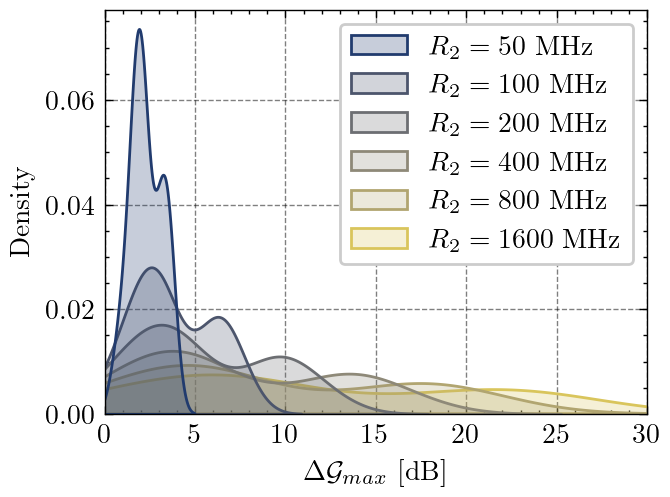

In [112]:
fig, ax = plt.subplots(dpi=200)
ax      = sns.kdeplot(deltaG.iloc[:,1:], color=BLUE_COLOR, fill=True, palette='cividis', log_scale=False)
_       = ax.set_xlim(0.0,30)
_       = ax.set_xlabel("$\\Delta \\mathcal{G}_{max}$ [dB]")

fig.savefig(f"plots/pdf/delta_G_max_vs_R_dist.pdf", transparent=False)
fig.savefig(f"plots/svg/delta_G_max_vs_R_dist.svg", transparent=True)
fig.savefig(f"plots/png/delta_G_max_vs_R_dist.png", transparent=False)

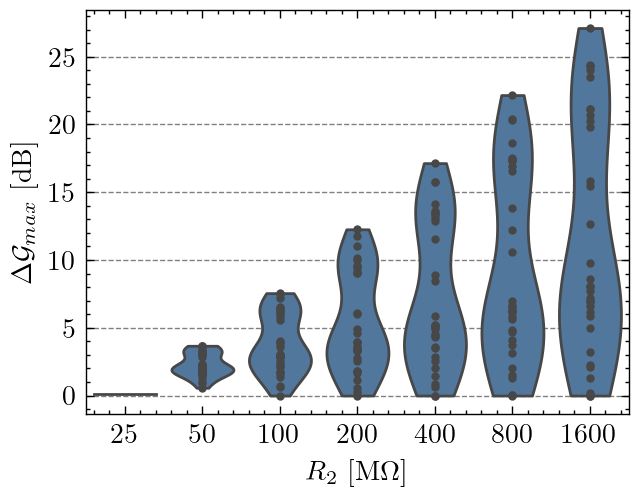

In [113]:
fig, ax = plt.subplots(dpi=200)
ax      = sns.violinplot(deltaG.rename(columns={f"$R_2 = {R}$ MHz":R for R in [25]+R_VALS}), color=BLUE_COLOR, fill=True, cut=0, inner='point', scale='width')
_       = ax.set_xlabel("$R_2$ [M$\Omega$]")
_       = ax.set_ylabel("$\\Delta \\mathcal{G}_{max}$ [dB]")

fig.savefig(f"plots/pdf/delta_G_max_vs_R.pdf", transparent=False)
fig.savefig(f"plots/svg/delta_G_max_vs_R.svg", transparent=True)
fig.savefig(f"plots/png/delta_G_max_vs_R.png", transparent=False)

/home/jonasmensing/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jonasmensing/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


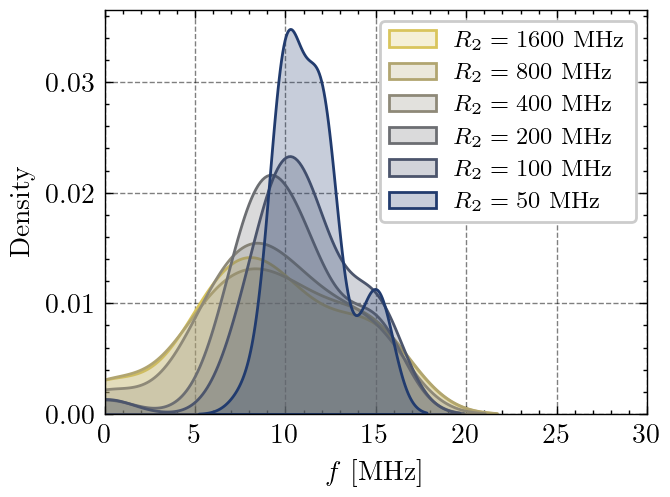

In [226]:
fig, ax = plt.subplots(dpi=200)
ax      = sns.kdeplot(f_at_max_gain, color=BLUE_COLOR, fill=True, palette='cividis', legend=False)
_       = ax.set_xlim(0.0,30)
_       = ax.set_xlabel("$f$ [MHz]")

# Update legend
new_labels = [f"$R_2 = {R}$ MHz" for R in R_VALS]
_ = ax.legend(new_labels[::-1], loc="upper right", fontsize='small', ncol=1)

fig.savefig(f"plots/pdf/f_at_max_gain.pdf", transparent=False)
fig.savefig(f"plots/svg/f_at_max_gain.svg", transparent=True)
fig.savefig(f"plots/png/f_at_max_gain.png", transparent=False)

### Min Mid Max Gain

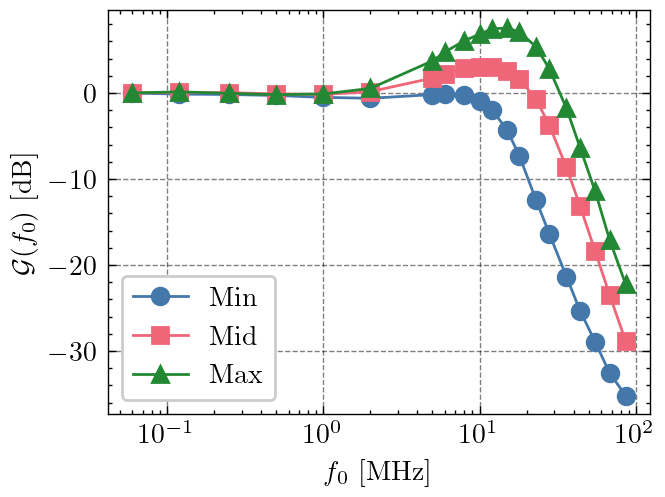

In [118]:
R       = 100
idx_g   = [np.argsort(deltaG[f"$R_2 = {R}$ MHz"].values)[0],
           np.argsort(deltaG[f"$R_2 = {R}$ MHz"].values)[16],
           np.argsort(deltaG[f"$R_2 = {R}$ MHz"].values)[-1]]

ma  = ['o','s','^']
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
for n, i in enumerate(idx_g):
    _   = ax.errorbar(FREQ_LIST_MHZ, gain_data[R][i], marker=ma[n])
_   = ax.set_xlabel("$f_0$ [MHz]")
_   = ax.set_ylabel("$\\mathcal{G}(f_0)$ [dB]")
_   = ax.set_xscale('log')
_   = ax.legend(['Min','Mid','Max'])

fig.savefig(f"plots/pdf/gain_vs_f0_at_R_{R}.pdf", transparent=False)
fig.savefig(f"plots/svg/gain_vs_f0_at_R_{R}.svg", transparent=True)
fig.savefig(f"plots/png/gain_vs_f0_at_R_{R}.png", transparent=False)

### Nonlinearity

In [119]:
def compute_spectral_centroid(amplitudes, harmonic_orders, exclude_fundamental=True):
    """
    Calculates the Spectral Centroid (Center of Mass of the Harmonic Spectrum).
    
    Formula: C = Sum(n * A_n^2) / Sum(A_n^2)
    (Weighted by Power, consistent with energy distribution)
    
    Parameters:
    - amplitudes: Array of magnitudes [A_1, A_3, A_5...]
    - harmonic_orders: Array of harmonic indices [1, 3, 5...]
    - exclude_fundamental: If True, calculates the centroid of the DISTORTION only (n > 1).
                           If False, includes the fundamental frequency.
    
    Returns:
    - centroid: The weighted average harmonic order (e.g., 3.5 means energy is between n=3 and n=5).
    """
    # Ensure inputs are numpy arrays
    amps = np.asarray(amplitudes)
    ords = np.asarray(harmonic_orders)
    
    # 1. Filter: Decide whether to include n=1
    if exclude_fundamental:
        # Only keep harmonics where n > 1
        mask = ords > 1
        valid_amps = amps[mask]
        valid_ords = ords[mask]
    else:
        valid_amps = amps
        valid_ords = ords
        
    # 2. Calculate Power (Square of Amplitude)
    power = valid_amps**2
    total_power = np.sum(power)
    
    # 3. Safety Check for Zero Distortion
    if total_power < 1e-20:
        return np.nan # No harmonic energy exists
        
    # 4. Calculate Centroid
    # Sum(n * Power) / Sum(Power)
    centroid = np.sum(valid_ords * power) / total_power
    
    return centroid

def compute_thd(amplitudes):
    """
    Calculates Total Harmonic Distortion (THD).
    Input: Array of amplitudes [A_fund, A_harm1, A_harm2, ...]
    """
    if len(amplitudes) < 2 or amplitudes[0] == 0:
        return 0.0
        
    power_fund = amplitudes[0]**2
    power_harm = np.sum(amplitudes[1:]**2)
    
    return np.sqrt(power_harm) / np.sqrt(power_fund)

In [227]:
N_periods   = 20
dim         = 9
n_vals      = np.arange(1,dim+1,1)
amplitudes  = {}
for R in R_VALS:
    amplitudes[R] = {}
    for n in range(N_NETS):
        amplitudes[R][n] = np.array([extract_harmonic_features(y[R][n][f0],n_vals,mode='abs') for f0 in FREQ_LIST_MHZ])
centr   = {R : {n : [compute_spectral_centroid(amplitudes[R][n][i], n_vals, True) for i in range(len(FREQ_LIST_MHZ))] for n in range(N_NETS)} for R in R_VALS}
thds    = {R : {n : [compute_thd(amplitudes[R][n][i]) for i in range(len(FREQ_LIST_MHZ))] for n in range(N_NETS)} for R in R_VALS}
thds_u  = [compute_thd(extract_harmonic_features(y_u[f0],n_vals,mode='abs')) for f0 in FREQ_LIST_MHZ]
centr_u = [compute_spectral_centroid(extract_harmonic_features(y_u[f0],n_vals,mode='abs'),n_vals) for f0 in FREQ_LIST_MHZ]

f_at_max_thd = pd.DataFrame([[FREQ_LIST_MHZ[np.argmax(thds[R][n])] for R in R_VALS] for n in range(N_NETS)], columns=R_VALS)

In [183]:
thd_df      = pd.DataFrame()
centr_df    = pd.DataFrame()
for R, val in thds.items():
    df          = pd.DataFrame(val)
    df['f0']    = FREQ_LIST_MHZ
    df          = df.melt(id_vars='f0',var_name='n',value_name='thd')
    df['R']     = R
    thd_df      = pd.concat([thd_df,df],ignore_index=True)

    df          = pd.DataFrame(centr[R])
    df['f0']    = FREQ_LIST_MHZ
    df          = df.melt(id_vars='f0',var_name='n',value_name='centr')
    df['R']     = R
    centr_df    = pd.concat([centr_df,df],ignore_index=True)

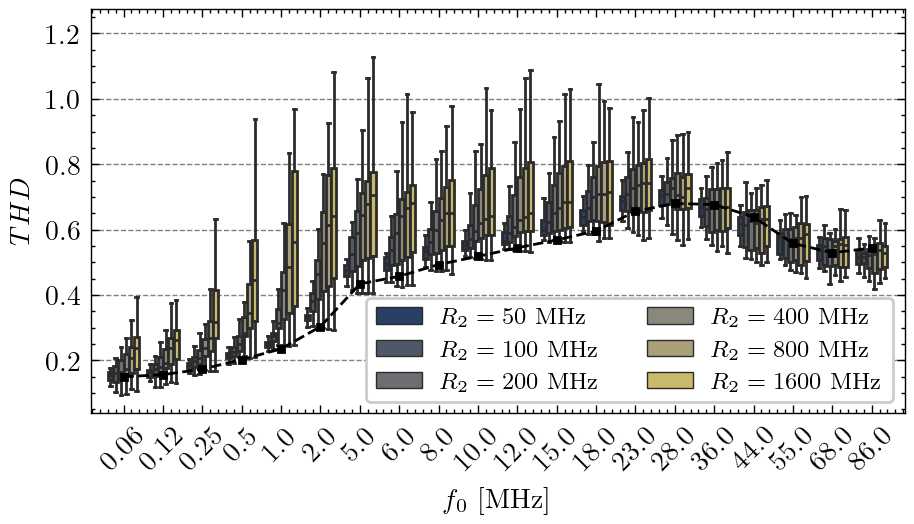

In [ ]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*1.5)
ax  = fig.add_subplot()
ax  = sns.boxplot(thd_df, x='f0', y='thd', hue='R', ax=ax, color=BLUE_COLOR, palette='cividis', fliersize=0)
_   = ax.set_ylabel("$THD$")
_   = ax.set_xlabel("$f_0$ [MHz]")
_   = ax.plot(thds_u, color='black', ls='--', marker='s', zorder=10, ms=2)
_   = plt.xticks(rotation=45)

# Update legend
handles, labels = ax.get_legend_handles_labels()
new_labels = [f"$R_2 = {R}$ MHz" for R in R_VALS]
_ = ax.legend(handles=handles, labels=new_labels, loc="lower right", fontsize='small', ncol=2)

fig.savefig(f"plots/pdf/thd_box_vs_f0_vs_R.pdf", transparent=False)
fig.savefig(f"plots/svg/thd_box_vs_f0_vs_R.svg", transparent=True)
fig.savefig(f"plots/png/thd_box_vs_f0_vs_R.png", transparent=False)

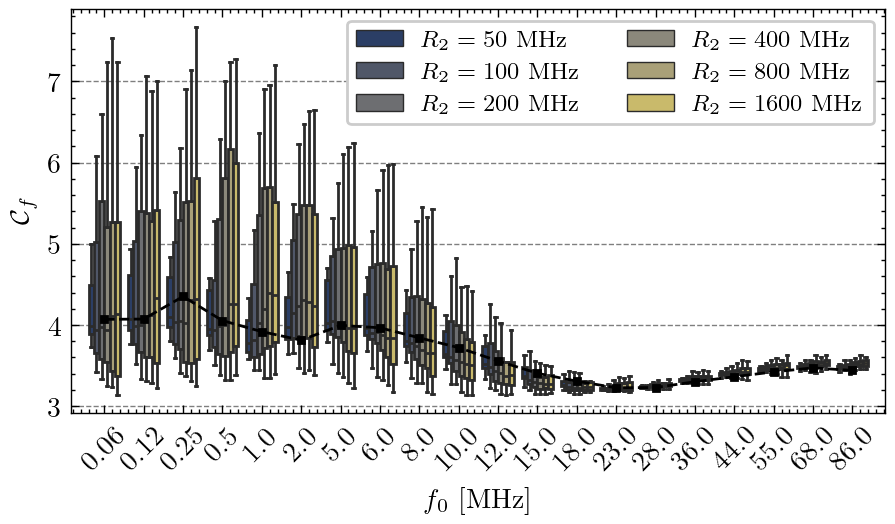

In [190]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*1.5)
ax  = fig.add_subplot()
ax  = sns.boxplot(centr_df, x='f0', y='centr', hue='R', ax=ax, color=BLUE_COLOR, palette='cividis', fliersize=0)
_   = ax.set_ylabel("$\mathcal{C}_f$")
_   = ax.set_xlabel("$f_0$ [MHz]")
_   = ax.plot(centr_u, color='black', ls='--', marker='s', zorder=10, ms=2)
_   = plt.xticks(rotation=45)

# Update legend
handles, labels = ax.get_legend_handles_labels()
new_labels = [f"$R_2 = {R}$ MHz" for R in R_VALS]
_ = ax.legend(handles=handles, labels=new_labels, loc="upper right", fontsize='small', ncol=2)

fig.savefig(f"plots/pdf/Cf_box_vs_f0_vs_R.pdf", transparent=False)
fig.savefig(f"plots/svg/Cf_box_vs_f0_vs_R.svg", transparent=True)
fig.savefig(f"plots/png/Cf_box_vs_f0_vs_R.png", transparent=False)

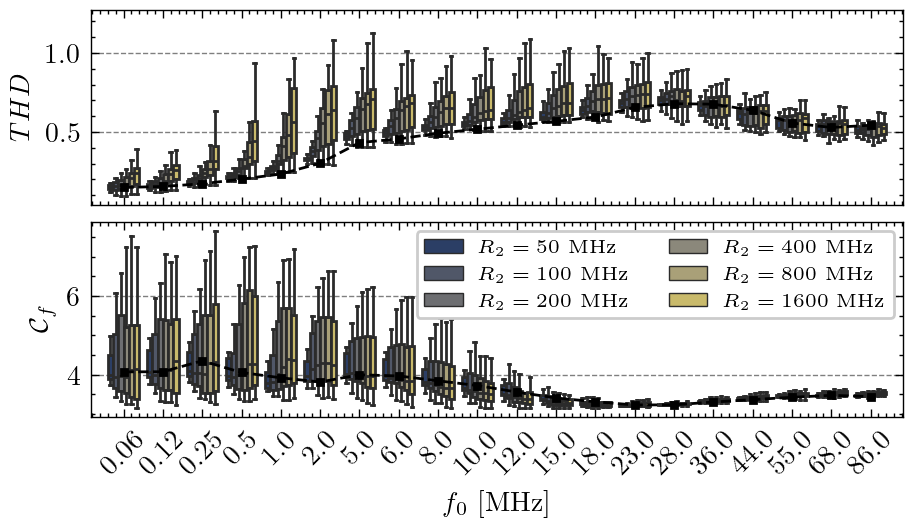

In [204]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.3)
ax  = fig.add_subplot(2,1,1)
ax  = sns.boxplot(thd_df, x='f0', y='thd', hue='R', ax=ax, color=BLUE_COLOR, palette='cividis', fliersize=0)
_   = ax.set_ylabel("$THD$")
_   = ax.set_xlabel("")
_   = ax.set_xticklabels("")
_   = ax.plot(thds_u, color='black', ls='--', marker='s', zorder=10, ms=2)
_   = plt.xticks(rotation=45)
ax.get_legend().remove()

ax  = fig.add_subplot(2,1,2)
ax  = sns.boxplot(centr_df, x='f0', y='centr', hue='R', ax=ax, color=BLUE_COLOR, palette='cividis', fliersize=0)
_   = ax.set_ylabel("$\mathcal{C}_f$")
_   = ax.set_xlabel("$f_0$ [MHz]")
_   = ax.plot(centr_u, color='black', ls='--', marker='s', zorder=10, ms=2)
_   = plt.xticks(rotation=45)

# Update legend
handles, labels = ax.get_legend_handles_labels()
new_labels = [f"$R_2 = {R}$ MHz" for R in R_VALS]
_ = ax.legend(handles=handles, labels=new_labels, loc="upper right", fontsize='x-small', ncol=2)

fig.savefig(f"plots/pdf/thd_and_Cf_box_vs_f0_vs_R.pdf", transparent=False)
fig.savefig(f"plots/svg/thd_and_Cf_box_vs_f0_vs_R.svg", transparent=True)
fig.savefig(f"plots/png/thd_and_Cf_box_vs_f0_vs_R.png", transparent=False)

/home/jonasmensing/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jonasmensing/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


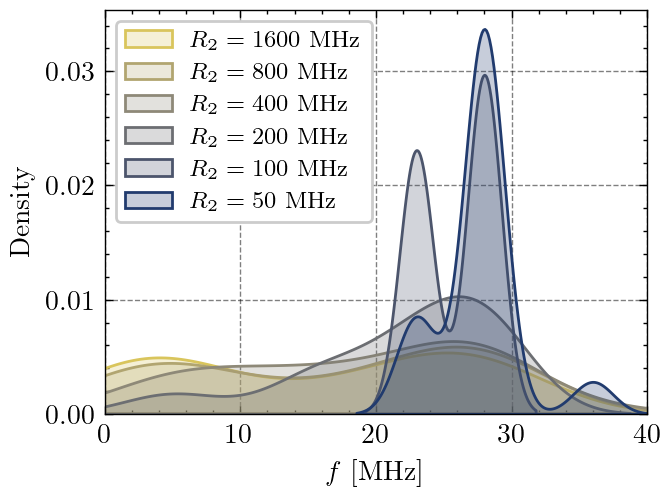

In [231]:
fig, ax = plt.subplots(dpi=200)
ax      = sns.kdeplot(f_at_max_thd, color=BLUE_COLOR, fill=True, palette='cividis', legend=False)
_       = ax.set_xlim(0.0,40)
_       = ax.set_xlabel("$f$ [MHz]")

# Update legend
new_labels = [f"$R_2 = {R}$ MHz" for R in R_VALS]
_ = ax.legend(new_labels[::-1], loc="upper left", fontsize='small', ncol=1)

fig.savefig(f"plots/pdf/f_at_max_thd.pdf", transparent=False)
fig.savefig(f"plots/svg/f_at_max_thd.svg", transparent=True)
fig.savefig(f"plots/png/f_at_max_thd.png", transparent=False)

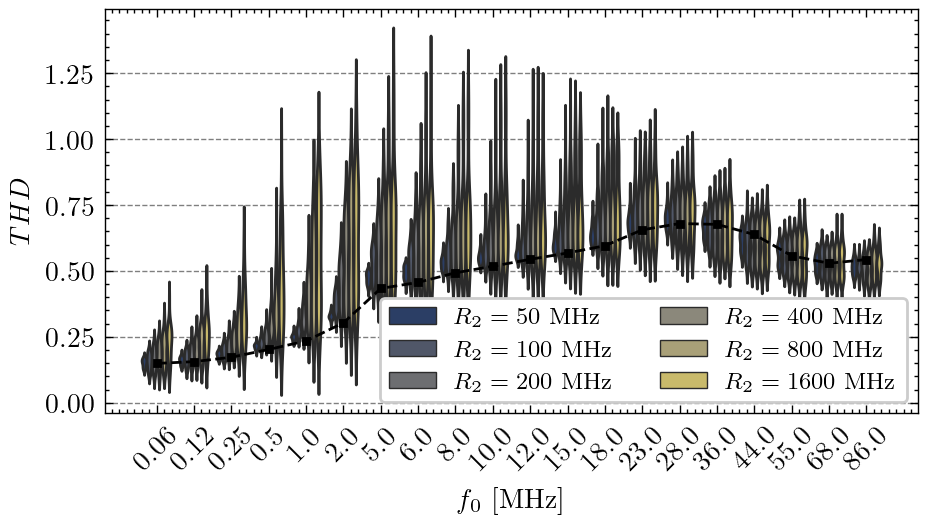

In [191]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*1.5)
ax  = fig.add_subplot()
ax  = sns.violinplot(thd_df, x='f0', y='thd', hue='R', ax=ax, color=BLUE_COLOR, scale='width', inner=None, palette='cividis')
_   = ax.set_ylabel("$THD$")
_   = ax.set_xlabel("$f_0$ [MHz]")
_   = ax.plot(thds_u, color='black', ls='--', marker='s', zorder=10, ms=2)
_   = plt.xticks(rotation=45)

# Update legend
handles, labels = ax.get_legend_handles_labels()
new_labels = [f"$R_2 = {R}$ MHz" for R in R_VALS]
_ = ax.legend(handles=handles, labels=new_labels, loc="lower right", fontsize='small', ncol=2)

fig.savefig(f"plots/pdf/thd_violin_vs_f0_vs_R.pdf", transparent=False)
fig.savefig(f"plots/svg/thd_violin_vs_f0_vs_R.svg", transparent=True)
fig.savefig(f"plots/png/thd_violin_vs_f0_vs_R.png", transparent=False)

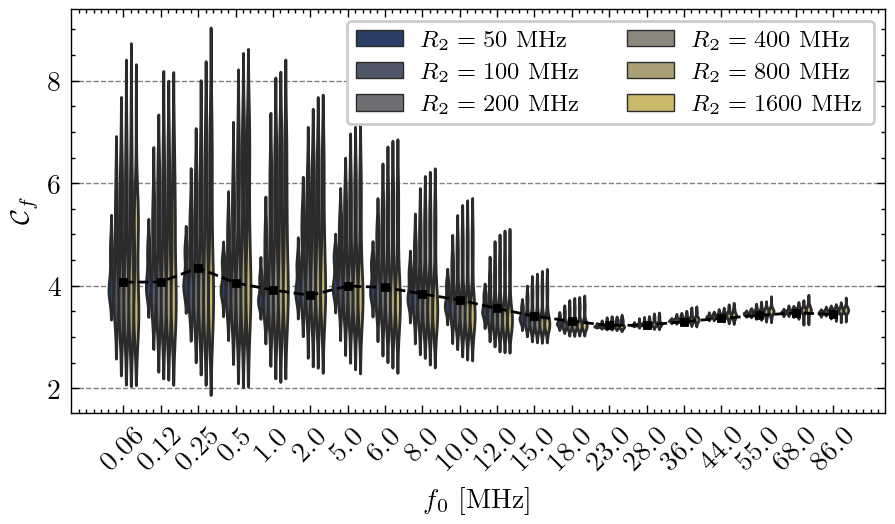

In [192]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*1.5)
ax  = fig.add_subplot()
ax  = sns.violinplot(centr_df, x='f0', y='centr', hue='R', ax=ax, color=BLUE_COLOR, scale='width', inner=None, palette='cividis')
_   = ax.set_ylabel("$\mathcal{C}_f$")
_   = ax.set_xlabel("$f_0$ [MHz]")
_   = ax.plot(centr_u, color='black', ls='--', marker='s', zorder=10, ms=2)
_   = plt.xticks(rotation=45)

# Update legend
handles, labels = ax.get_legend_handles_labels()
new_labels = [f"$R_2 = {R}$ MHz" for R in R_VALS]
_ = ax.legend(handles=handles, labels=new_labels, loc="upper right", fontsize='small', ncol=2)

fig.savefig(f"plots/pdf/Cf_violin_vs_f0_vs_R.pdf", transparent=False)
fig.savefig(f"plots/svg/Cf_violin_vs_f0_vs_R.svg", transparent=True)
fig.savefig(f"plots/png/Cf_violin_vs_f0_vs_R.png", transparent=False)

---

### Load Network Currents at min/mid/max Gain and THD

In [ ]:
# R = 100
R      = 1600
idx_g  = [np.argsort(deltaG[R].values)[0],
          np.argsort(deltaG[R].values)[16],
          np.argsort(deltaG[R].values)[-1]]
idx_b  = [15,30,20]

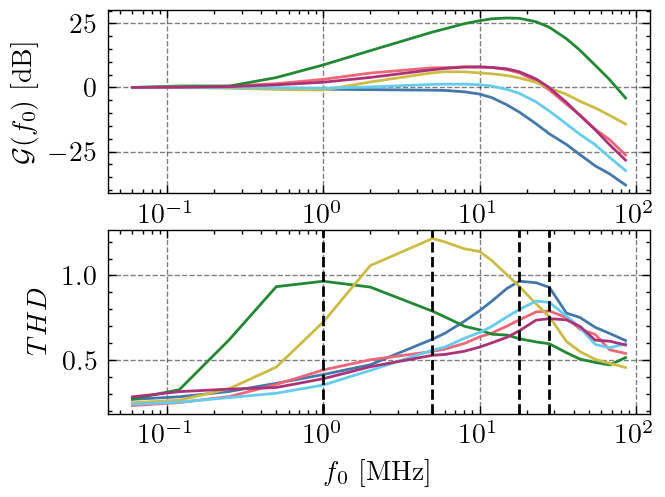

In [82]:
gain_at_idx = [gain_data[R].copy()[i]['gain'] for i in idx_g+idx_b]
thd_at_idx  = [thds[R].copy()[i] for i in idx_g+idx_b]
fig = plt.figure(dpi=200)
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
for val1, val2 in zip(gain_at_idx,thd_at_idx):
       _   = ax1.plot(FREQ_LIST_MHZ, val1)
       _   = ax2.plot(FREQ_LIST_MHZ, val2)
for f_val in [1.0,18.0,28.0,5.0]:
       _   = plt.axvline(f_val, color='black', ls='--')
_   = ax2.set_xlabel("$f_0$ [MHz]")
_   = ax1.set_ylabel("$\\mathcal{G}(f_0)$ [dB]")
_   = ax2.set_ylabel("$THD$")
_   = ax1.set_xscale('log')
_   = ax2.set_xscale('log')

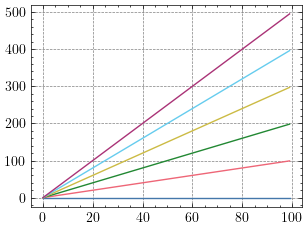

In [5]:
for i in range(6):
    plt.plot(i*np.arange(100))

- idx_vals for Min,Mid,Max Gain = [12,9,4]
- idx_vals for Min,Max Beta = [15,20] 
- f0_vals = [1.0,18.0,28.0]

In [ ]:
min_G_idx   = 30
max_G_idx   = 4
GAIN_IDX    = [min_G_idx, max_G_idx]
min_THD_idx = 19
max_THD_idx = 15
THD_IDX     = [min_THD_idx, max_THD_idx]
currents    = {}
for R in R_VALS:
    currents[R] = {n : {freq : pd.read_csv(f"{PATH}net_currents_Nx=9_Ny=9_Ne=8_{freq:.3f}_mean2_{R:.1f}_{n}.csv").iloc[N_SKIP*SAMPLE_P_PERIOD:,:]*1e-6
                        for freq in FREQ_LIST_MHZ} for n in [min_G_idx, max_G_idx, min_THD_idx, max_THD_idx]}

### Min Gain vs Max Gain

In [187]:
active_bonds_min_gain = {}
active_bonds_max_gain = {}
for R in R_VALS:
    l1_tmp = []
    l2_tmp = []
    for f0 in FREQ_LIST_MHZ:
        df_net  = get_net_currents(currents[R][min_G_idx][f0])
        # df_net  = currents[R][min_G_idx][f0]
        N_bond  = len(df_net.columns)
        rms     = np.sqrt((df_net**2).sum())
        P_min   = np.sum(rms)**2 / (N_bond * np.sum(rms**2))
        l1_tmp.append(P_min)

        df_net  = get_net_currents(currents[R][max_G_idx][f0])
        # df_net  = currents[R][max_G_idx][f0]
        N_bond  = len(df_net.columns)
        rms     = np.sqrt((df_net**2).sum())
        P_max   = np.sum(rms)**2 / (N_bond * np.sum(rms**2))
        l2_tmp.append(P_max)

    active_bonds_min_gain[R] = l1_tmp
    active_bonds_max_gain[R] = l2_tmp

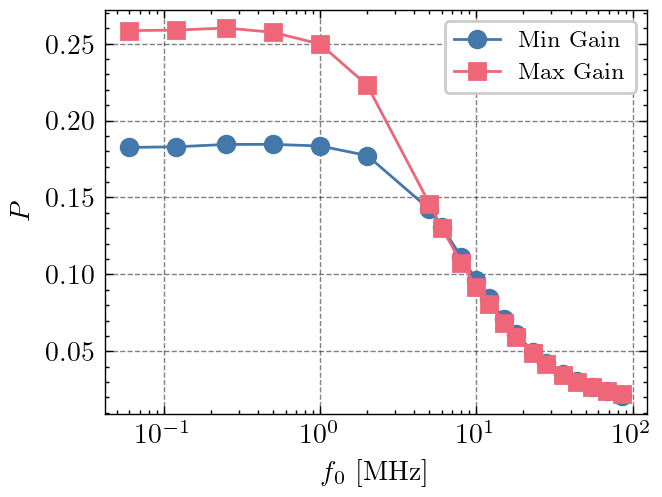

In [ ]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
_   = ax.plot(FREQ_LIST_MHZ, active_bonds_min_gain[1600], 'o-', label='Min Gain')
_   = ax.plot(FREQ_LIST_MHZ, active_bonds_max_gain[1600], 's-', label='Max Gain')
_   = ax.set_xscale('log')
_   = ax.legend(fontsize='small')
_   = ax.set_xlabel("$f_0$ [MHz]")
_   = ax.set_ylabel("$P$")

fig.savefig(f"plots/pdf/P_vs_f0_at_R2_1600.pdf", transparent=False)
fig.savefig(f"plots/svg/P_vs_f0_at_R2_1600.svg", transparent=True)
fig.savefig(f"plots/svg/P_vs_f0_at_R2_1600.png", transparent=False)

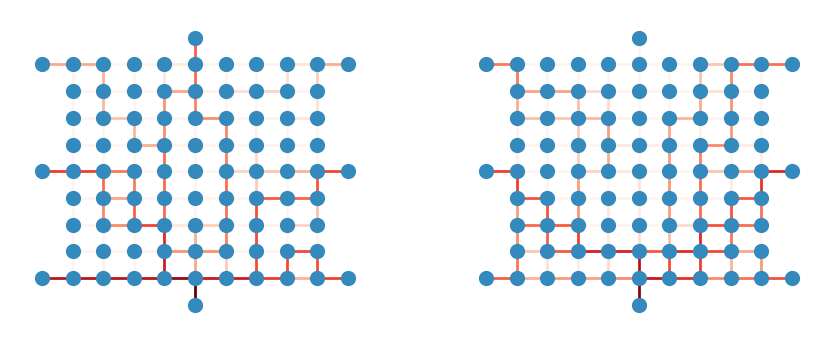

In [323]:
f0  = 0.06
fig = plt.figure(dpi=200)
fig.set_figheight(fig.get_figheight()*0.8)
fig.set_figwidth(fig.get_figwidth()*1.5)
leg_labels  = ['Min Gain', 'Max Gain']
for i, n in enumerate(GAIN_IDX):
    ax      = fig.add_subplot(1,2,i+1)
    df_net  = get_net_currents(currents[1600][n][f0].copy())
    rms     = np.sqrt((df_net**2).sum())
    G       = create_weighted_undirected_graph(rms)
    ax      = display_net_flow_graph(G, pos=pos, log_sacle=True, font_size=None, ax=ax, vmin=10, vmax=1500, node_size=20)
    # _       = ax.set_title(leg_labels[i])

fig.savefig(f"plots/pdf/network_currents_min_vs_max_gain.pdf", transparent=False)
fig.savefig(f"plots/svg/network_currents_min_vs_max_gain.svg", transparent=True)
fig.savefig(f"plots/png/network_currents_min_vs_max_gain.png", transparent=False)

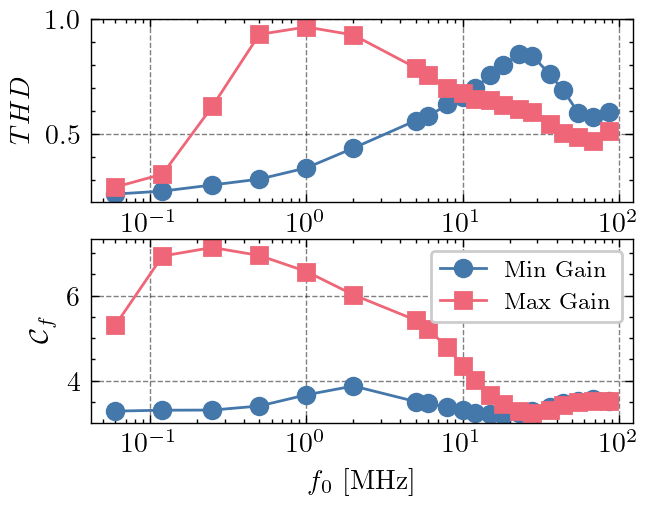

In [318]:
leg_labels  = ['Min Gain', 'Max Gain']
marker      = ['o','s','^']
R_VALUE     = 1600
fig         = plt.figure(dpi=200)
ax          = fig.add_subplot(2,1,1)
for i, n in enumerate(GAIN_IDX):
    THD_val = thds[R_VALUE][n]
    _       = ax.plot(FREQ_LIST_MHZ, THD_val, marker=marker[i])
_   = ax.set_xscale('log')
_   = ax.set_ylabel('$THD$')
ax  = fig.add_subplot(2,1,2)
for i, n in enumerate(GAIN_IDX):
    c_val   = centr[R_VALUE][n]
    _       = ax.plot(FREQ_LIST_MHZ, c_val, marker=marker[i], label=leg_labels[i])
_   = ax.set_xscale('log')
_   = ax.set_xlabel("$f_0$ [MHz]")
_   = ax.set_ylabel('$\mathcal{C}_f$')
_   = ax.legend(fontsize='small', loc='upper right')

fig.savefig(f"plots/pdf/nonlinearity_min_vs_max_gain.pdf", transparent=False)
fig.savefig(f"plots/svg/nonlinearity_min_vs_max_gain.svg", transparent=True)
fig.savefig(f"plots/png/nonlinearity_min_vs_max_gain.png", transparent=False)

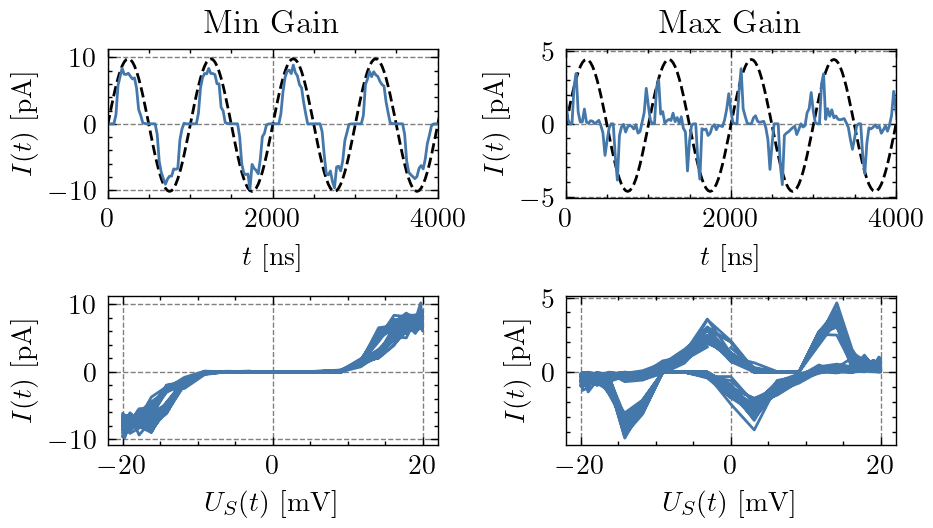

In [319]:
titles = ["Min Gain","Max Gain"]
f0s = 1.0
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.8)
for i, n in enumerate(GAIN_IDX):
    ax      = fig.add_subplot(2,3,i+1)
    t_val   = time[f0s].copy()[:-(N_SKIP*SAMPLE_P_PERIOD)-1]
    x_val   = x[R_VALUE][n][f0s].copy()
    y_val   = y[R_VALUE][n][f0s].copy()*1e-6
    _       = ax.plot(t_val*1e9, y_val)
    _       = ax.plot(t_val*1e9, (y_val.max() - y_val.min())*(x_val-x_val.min()) / (x_val.max() - x_val.min()) - y_val.max(), color='black', ls='--', zorder=0.1)
    _       = ax.set_xlim(0,t_val[SAMPLE_P_PERIOD*4]*1e9)
    _       = ax.set_xlabel("$t$ [ns]")
    _       = ax.set_ylabel("$I(t)$ [pA]")
    _       = ax.set_title(titles[i])
for i, n in enumerate(GAIN_IDX):
    ax      = fig.add_subplot(2,3,i+4)
    t_val   = time[f0s].copy()[:-(N_SKIP*SAMPLE_P_PERIOD)-1]
    x_val   = x[R_VALUE][n][f0s].copy()*1000
    y_val   = y[R_VALUE][n][f0s].copy()*1e-6
    _       = ax.plot(x_val, y_val)
    _       = ax.set_xlabel("$U_S(t)$ [mV]")
    _       = ax.set_ylabel("$I(t)$ [pA]")

fig.savefig(f"plots/pdf/current_reponses_min_vs_max_gain_{f0s}.pdf", transparent=False)
fig.savefig(f"plots/svg/current_reponses_min_vs_max_gain_{f0s}.svg", transparent=True)
fig.savefig(f"plots/png/current_reponses_min_vs_max_gain_{f0s}.png", transparent=False)

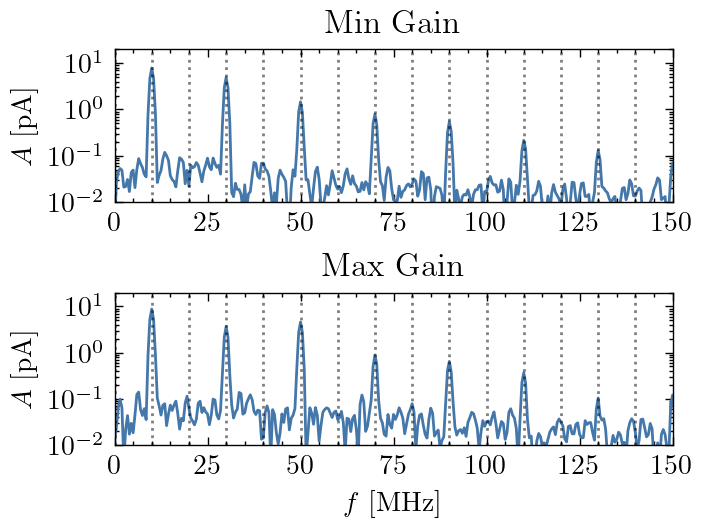

In [312]:
def get_frequency_spectrum(signal, dt):
    """
    Computes the calibrated one-sided amplitude spectrum.
    
    Parameters:
    - signal: 1D numpy array (time domain)
    - dt: Time step in seconds
    
    Returns:
    - freqs: Array of frequencies [Hz]
    - amplitudes: Array of physical amplitudes [A] (or whatever unit signal is in)
    """
    N_samples = len(signal)
    
    # 1. Apply Window (Consistent with your previous analysis)
    window = np.blackman(N_samples)
    y_windowed = signal * window
    
    # Window Coherent Gain Correction
    w_gain = np.sum(window) / N_samples
    
    # 2. Compute FFT
    fft_vals = np.fft.rfft(y_windowed)
    freqs = np.fft.rfftfreq(N_samples, dt)
    
    # 3. Normalize Magnitude
    # Scale for one-sided (*2), normalize by N, correct for window loss
    amplitudes = (np.abs(fft_vals) * 2 / N_samples) / w_gain
    
    return freqs, amplitudes

f0_val  = 10. #5.0 #0.5
fig     = plt.figure(dpi=200, layout='constrained')
for i, n in enumerate(GAIN_IDX):
    y_val   = y[R_VALUE][n][f0_val]
    xf, yf  = get_frequency_spectrum(y_val,dts[f0_val])
    ax      = fig.add_subplot(len(GAIN_IDX),1,i+1)
    _       = ax.semilogy(xf*1e-6, yf*1e-6)
    _       = ax.set_ylabel('$A$ [pA]')
    _       = ax.set_xlim(0,15*f0_val)
    _       = ax.set_ylim(0.01,20)
    _       = ax.set_title(titles[i])
    ax.grid(False)
    for n in range(15):
        plt.axvline(n*f0_val, color='black', ls=':', alpha=0.5)
_ = ax.set_xlabel("$f$ [MHz]")

fig.savefig(f"plots/pdf/frequency_reponses_min_vs_max_gain_{f0_val}.pdf", transparent=False)
fig.savefig(f"plots/svg/frequency_reponses_min_vs_max_gain_{f0_val}.svg", transparent=True)
fig.savefig(f"plots/png/frequency_reponses_min_vs_max_gain_{f0_val}.png", transparent=False)

### Current Percolation

In [45]:
NET_INDEX = [min_G_idx, max_G_idx]

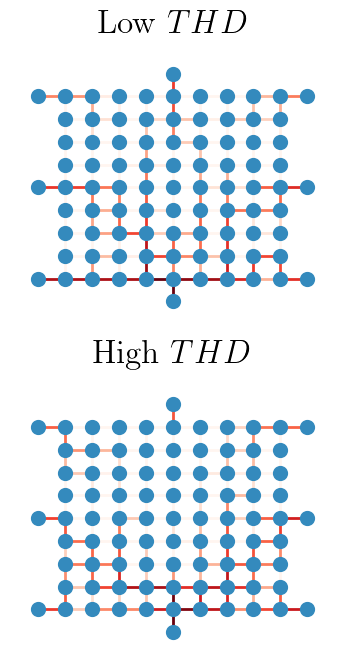

In [46]:
f0  = 5.0
fig = plt.figure(dpi=200)
fig.set_figheight(fig.get_figheight()*1.5)
fig.set_figwidth(fig.get_figwidth()*0.6)
for i, n in enumerate(NET_INDEX):
    ax      = fig.add_subplot(2,1,i+1)
    df_net  = get_net_currents(currents[R_VALUE][n][f0].copy())
    rms     = np.sqrt((df_net**2).sum())
    G       = create_weighted_undirected_graph(rms)
    ax      = display_net_flow_graph(G, pos=pos, log_sacle=True, font_size=None, ax=ax, vmin=10, vmax=1000, node_size=20)
    _       = ax.set_title(titles[i])
# fig.savefig(f"plots/pdf/network_currents_spec_Rs.pdf", transparent=False)
# fig.savefig(f"plots/svg/network_currents_spec_Rs.svg", transparent=True)
# fig.savefig(f"plots/png/network_currents_spec_Rs.png", transparent=False)

---